## MI between descriptors and embeddings

In [1]:
%cd ..

/home/philippe/InfEmb/emir/molecule


In [2]:
import os
import sys

#change working dir

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from molecule.utils.utils_notebook import get_MI_df, plot_cmap, plot_com, get_ranked_df, LATEX_FIG_PATH,plot_embeddings

DATASET = "ZINC"
COLUMS_SPLIT = "cond_modes"

import json
with open(f"data/ZINC/smiles.json", "r") as f:
    s = json.load(f)
N = len(s)


2024-05-14 13:43:11,524 - main - INFO - Logger is set.


In [ ]:
plot_embeddings(DATASET, figsize=10,alpha=0.05, desc="qed", n_mols=10000, min_hue=0.5,)


In [3]:
def add_BIC_AIC(df):
    df["n_params_marg"] = df["marg_modes"] * df["Y_dim"] * 2 + df["marg_modes"]
    df["n_params_cond"] =df["ff_hidden_dim"] * ( 2 * df["cond_modes"] * df["Y_dim"] + df["X_dim"] + df["ff_hidden_dim"] * df["ff_layers"] + df["cond_modes"])
    df["n_params_cond_no_ff"] = 2 * df["cond_modes"] * df["Y_dim"] + df["cond_modes"]

    df["BIC_marg"] =np.log(N) * df["n_params_marg"] + 2 * df["I(Y)"] * N
    df["BIC_cond"] =np.log(N) * df["n_params_cond"] + 2 * df["I(X->Y)"] * N
    df["BIC_cond_no_ff"] =np.log(N) * df["n_params_cond_no_ff"] + 2 * df["I(X->Y)"] * N
    df["BIC"] = df["BIC_marg"]  + df["BIC_cond"]
    df["BIC_no_ff"] = df["BIC_marg"]  + df["BIC_cond_no_ff"]

    df["Likelihood_marg"] =  df["I(Y)"] * N
    df["Likelihood_cond"] =  df["I(X->Y)"] * N


    df["AIC_marg"] = 2 * df["n_params_marg"] + 2 * df["Likelihood_marg"]
    df["AIC_cond"] = 2 * df["n_params_cond"] + 2 * df["Likelihood_cond"]
    df["AIC_cond_no_ff"] = 2 * df["n_params_cond_no_ff"] + 2 * df["Likelihood_cond"]
    df["AIC"] = df["AIC_marg"]  + df["AIC_cond"]
    df["AIC_no_ff"] = df["AIC_marg"]  + df["AIC_cond_no_ff"]


    return df



In [4]:
results_dir_list = ["run_1", "run_2", "run_4", "run_8"]
df = get_MI_df(DATASET, results_dir_list)
df = add_BIC_AIC(df)

df[["X", "X_dim"]].drop_duplicates().set_index("X")

100%|██████████| 4/4 [00:00<00:00, 24.39it/s]


,X_dim
X,
DenoisingPretrainingPQCMv4,256
InfoGraph,300
ChemBertMTR-10M,384
MoleOOD_OGB_GCN,256
ChemGPT-19M,256
ChemBertMTR-5M,384
ChemBertMLM-77M,600
ContextPred,300
GraphMVP,300


In [145]:

from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import os
import pandas as pd


df_modes = pd.DataFrame(columns=["model", "log_likelihood", "n_clusters", "BIC", "AIC"])

CLUSTERS = list(range(1,9))
models = df["X"].unique()

p_bar = tqdm(total=len(models) * len(CLUSTERS))
try:
    for m in models:
        p_bar.desc = f"[{m}]:\t"
        if os.path.exists(f"data/{DATASET}/{m}.npy"):
            emb = np.load(f"data/{DATASET}/{m}.npy", mmap_mode="r")
            random_idx = np.random.choice(emb.shape[0], 5000, replace=False)
            emb = emb[random_idx]
            emb = np.unique(emb, axis=0)
            emb = (emb - emb.mean(axis=0)) / (emb.std(axis=0) + 1e-8)
            for n_clusters in CLUSTERS:
                g_mixt = GaussianMixture(n_components=n_clusters, random_state=0, covariance_type="full", max_iter=100, verbose=0).fit(emb)
                aic = g_mixt.aic(emb)
                bic = g_mixt.bic(emb)
                log_likelihood = g_mixt.score(emb)
                df_modes.loc[len(df_modes)] = [m, log_likelihood, n_clusters, bic, aic]
                p_bar.update(1)
except Exception as e:
    print(e)
finally:
    p_bar.close()
del p_bar


[ThreeDInfomax]:	: 100%|██████████| 224/224 [21:19<00:00,  5.71s/it]           


In [149]:
for k in ["BIC", "AIC", "log_likelihood"]:
    df_modes[f"{k}_norm"] = (df_modes.set_index("model")[k] / df_modes.groupby("model")[k].max()).reset_index()[k]

df_modes_joined = df_modes.join(df[["X", "X_dim"]].drop_duplicates().set_index("X"), on="model")

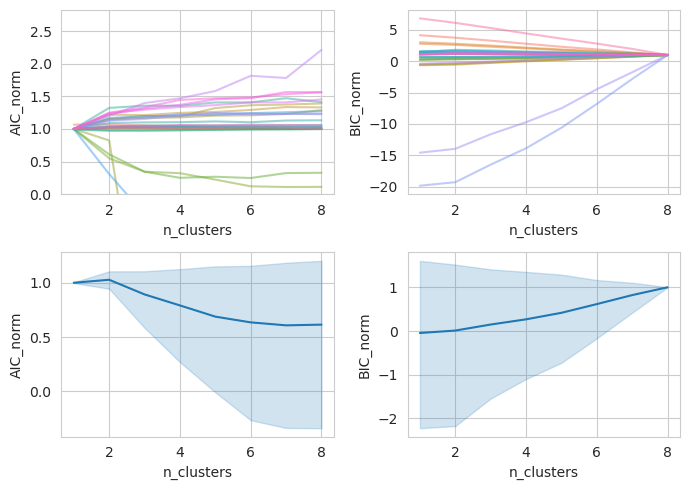

In [153]:
fig,axess = plt.subplots(2,2, figsize=(7,5))
axes = axess[0]
sns.lineplot(data=df_modes, x="n_clusters", y="AIC_norm", hue="model", legend=False, ax=axes[0], alpha = 0.5)
axes[0].set_ylim(0)
sns.lineplot(data=df_modes, x="n_clusters", y="BIC_norm", hue="model", legend=False, ax=axes[1], alpha= 0.5)

axes = axess[1]
sns.lineplot(data=df_modes, x="n_clusters", y="AIC_norm", legend=False, ax=axes[0])
sns.lineplot(data=df_modes, x="n_clusters", y="BIC_norm", legend=False, ax=axes[1])

fig.tight_layout()

<AxesSubplot:>

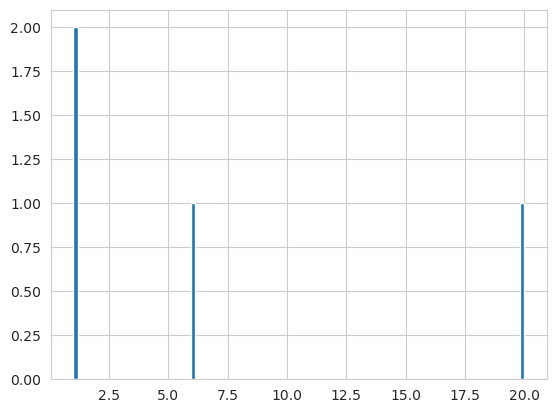

In [158]:
df_modes.loc[df_modes.groupby("model")["BIC"].idxmin()].n_clusters.value_counts().hist(bins=100)

<AxesSubplot:>

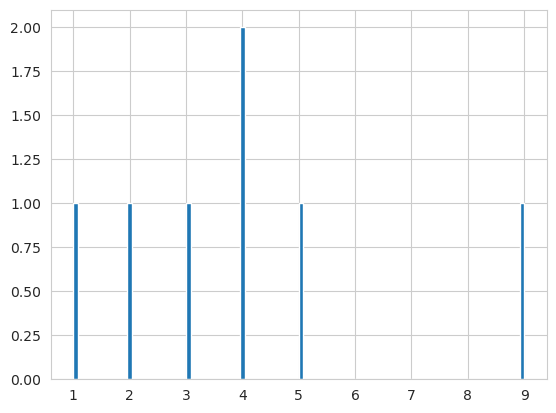

In [159]:
df_modes.loc[df_modes.groupby("model")["AIC"].idxmin()].n_clusters.value_counts().hist(bins=100)

In [ ]:
models = df["X"].unique()
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
import os
import pandas as pd

df_modes = pd.DataFrame(columns=["model", "d_inertia", "n_clusters"])


for m in tqdm(models):
    if os.path.exists(f"data/{DATASET}/{m}.npy"):
        emb = np.load(f"data/{DATASET}/{m}.npy", mmap_mode="r")
        lastinertia = None
        for n_clusters in range(1, 9):

            kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0).fit(emb)
            if lastinertia is not None:
                df_modes = df_modes.append({"model": m, "d_inertia": lastinertia - kmeans.inertia_, "n_clusters": n_clusters}, ignore_index=True)
            lastinertia = kmeans.inertia_


In [ ]:
df_modes["d_inertia_norm"] = (df_modes.set_index("model").d_inertia  / df_modes.groupby("model").d_inertia.min().abs()).reset_index().d_inertia


sns.lineplot(data=df_modes, x="n_clusters", y="d_inertia", hue="model", legend=False)

In [ ]:
sns.lineplot(data=df_modes, x="n_clusters", y="d_inertia_norm", hue="model", legend=False)